In [1]:
%matplotlib inline
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l
# import cv2 as cv
import os

In [2]:
## 构造模型
# 使用在ImageNet数据集上与训练的ResNet-18模型来提取图像特征

# pretrained开开得到权重
pretrained_net = torchvision.models.resnet18(pretrained=True)
list(pretrained_net.children())[-3:]
# children -3 看看最后三层啥样子
# 看出最后两层是不需要的


d:\miniconda\install\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\miniconda\install\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[Sequential(
   (0): BasicBlock(
     (conv1): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (downsample): Sequential(
       (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
       (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     )
   )
   (1): BasicBlock(
     (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): Batc

In [3]:
# 创建一个全卷积网络实例net
net = nn.Sequential(*list(pretrained_net.children())[:-2])

In [4]:
# 给定高度为320和宽度为480的输入，net的前向传播将输入的高和宽减小至原来的1/32
# 即10和15。
X = torch.rand(size=(64, 3, 7, 7))
net(X).shape

torch.Size([64, 512, 1, 1])

In [5]:
## 接下来使用卷积层将输出通道数转换为Pascal VOC2012数据集的类数（21类）。
## 最后需要将特征图的高度和宽度增加32倍，从而将其变回输入图像的高和宽。 
# 回想一下 6.3节中卷积层输出形状的计算方法： 由于
# （320-64+16*2+32）/32 = 10 且 （480-64+16*2+32）/32=15
# 我们构造一个步幅为32的转置卷积层，并将卷积核的高和宽设为64，填充16
# 我们可以看到如果步幅为s，填充为s/2（假设s/2是整数）且卷积核的高和宽为2s
# 转置卷积核会将输入的高和宽分别放大s倍。

# 输出21 分类21 计算量变小
num_classes = 21
net.add_module('final_conv', nn.Conv2d(512, num_classes, kernel_size=1))
net.add_module('transpose_conv', 
               nn.ConvTranspose2d(num_classes, 
                                  num_classes,
                                    kernel_size=64, 
                                    padding=16, 
                                    # 偶数 + 能取的最小的值
                                    # 放大32倍
                                    stride=32))

In [6]:
## 初始化转置卷积层
# 实现上采样-双线性插值（bilinear interpolation）
# 

def bilinear_kernel(in_channels, out_channels, kernel_size):
    factor = (kernel_size + 1) // 2
    if kernel_size % 2 == 1:
        center = factor - 1
    else:
        center = factor - 0.5
    og = (torch.arange(kernel_size).reshape(-1, 1),
          torch.arange(kernel_size).reshape(1, -1))
    filt = (1 - torch.abs(og[0] - center) / factor) * \
           (1 - torch.abs(og[1] - center) / factor)
    weight = torch.zeros((in_channels, out_channels,
                          kernel_size, kernel_size))
    weight[range(in_channels), range(out_channels), :, :] = filt
    return weight

In [7]:
# 双线性插值的上采样实验
conv_trans = nn.ConvTranspose2d(3, 3, kernel_size=4, padding=1, 
                                # 高宽放大2倍
                                stride=2,
                                bias=False)

# 用双线性插值的核来实现其权重，使得该函数变为双线性插值的操作
conv_trans.weight.data.copy_(bilinear_kernel(3, 3, 4));

In [19]:
#img = torchvision.transforms.ToTensor()(d2l.Image.open('../img/catdog.jpg'))

img = torchvision.transforms.ToTensor()(d2l.Image.open(r'E:\try\cat_dog.jpg'))
#img = open('E:/try/cat_dog.jpg')
# 图片放进来转成pytorch能用的tensor形式
# 对x做转置卷积的操作
X = img.unsqueeze(0)
Y = conv_trans(X)
out_img = Y[0].permute(1, 2, 0).detach()

input image shape: torch.Size([298, 473, 3])
output image shape: torch.Size([596, 946, 3])


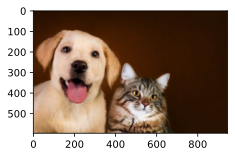

In [20]:
d2l.set_figsize()
print('input image shape:', img.permute(1, 2, 0).shape)
d2l.plt.imshow(img.permute(1, 2, 0));
print('output image shape:', out_img.shape)
d2l.plt.imshow(out_img);

# 看得出输出拉到了 跟原图基本没啥区别 
# 构造转置卷积层 原图变大2倍
# 双线性插值核初始权重 = 图片拉大效果
# 可以用来初始全卷积层的方法

In [10]:
# 用双线性插值的上采样初始化转置卷积层。
# 对于卷积层，我们使用Xavier初始化参数
W = bilinear_kernel(num_classes, num_classes, 64)
net.transpose_conv.weight.data.copy_(W);

In [11]:
## 读取数据集
# 指定随机裁剪的输出图像的形状为320*480
# 高和宽都可以被32整除

batch_size, crop_size = 1, (320, 480)

# 1.删除一部分数据集试试
# crop_size 减少

train_iter, test_iter = d2l.load_data_voc(batch_size, crop_size)



read 1114 examples
read 1078 examples


In [12]:
# 整合所有组件

#@save
def load_data_voc(batch_size, crop_size):
    """加载VOC语义分割数据集"""
    voc_dir = d2l.download_extract
    ('voc2012', os.path.join(
        'VOCdevkit', 'VOC2012'))
    num_workers = d2l.get_dataloader_workers()
    train_iter = torch.utils.data.DataLoader(
        VOCSegDataset(True, crop_size, voc_dir), batch_size,
        shuffle=True, drop_last=True, num_workers=num_workers)
    test_iter = torch.utils.data.DataLoader(
        VOCSegDataset(False, crop_size, voc_dir), batch_size,
        drop_last=True, num_workers=num_workers)
    return train_iter, test_iter

loss 0.962, train acc 0.775, test acc 0.804
21.7 examples/sec on [device(type='cuda', index=0)]


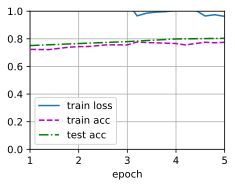

In [13]:
## 训练
# 损失有很多，是一个矩阵 每一个高+宽（矩阵）做平均 - 拿一个值

def loss(inputs, targets):
    return F.cross_entropy(inputs, targets, reduction='none').mean(1).mean(1)

num_epochs, lr, wd, devices = 5, 0.001, 1e-3, d2l.try_all_gpus()
trainer = torch.optim.SGD(net.parameters(), lr=lr, weight_decay=wd)
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

In [14]:
## 预测 测试集的dataset做normalization  
# 复制到GPU 通道维度做argmax 得到每个像素预测的标号
# reshape成与输入高宽一致的矩阵

def predict(img):
    X = test_iter.dataset.normalize_image(img).unsqueeze(0)
    pred = net(X.to(devices[0])).argmax(dim=1)
    return pred.reshape(pred.shape[1], pred.shape[2])

In [15]:
# 可视化预测的类别
# 每个像素预测值 变成img 类别RGB - tensor 画出来
def label2image(pred):
    colormap = torch.tensor(d2l.VOC_COLORMAP, device=devices[0])
    X = pred.long()
    return colormap[X, :]

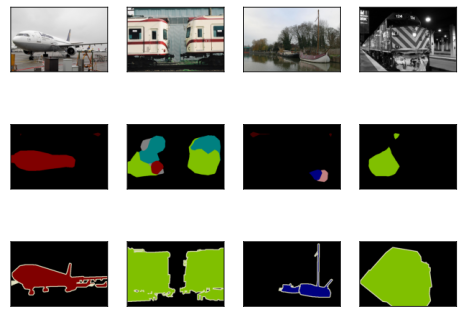

In [16]:
voc_dir = d2l.download_extract('voc2012', 'VOCdevkit/VOC2012')
test_images, test_labels = d2l.read_voc_images(voc_dir, False)
n, imgs = 4, []
for i in range(n):
    crop_rect = (0, 0, 320, 480) 
    # 左上角剪裁成需要大小
    X = torchvision.transforms.functional.crop(test_images[i], *crop_rect)
    # 预测转成图片
    pred = label2image(predict(X))
    imgs += [X.permute(1,2,0), pred.cpu(),
             torchvision.transforms.functional.crop(
                 test_labels[i], *crop_rect).permute(1,2,0)]
d2l.show_images(imgs[::3] + imgs[1::3] + imgs[2::3], 3, n, scale=2);